---
title: Predicting NES game prices on eBay - part 1: data preparation    
date: 2016-04-10  
comments: false  
tags: Python, Programming tips, Public Data   
keywords: python, programming, virtualenv, virtualfish, reproducible research  

---

The first thing I did was created a virtualenv with the following packages: X. Following this, I imported `urllib2`, `json`, `math`, `numpy`, `pandas` and `pandas` Series and DataFrames separately.

In [1]:
import urllib2
import json
import math

import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

/Users/jburchell/.virtualenvs/ebay_api/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


I then created a function that pulls expired listings for keywords of choice using the eBay API.

In [2]:
def expired_listings(site, searchterm):
    '''Extracts the total historical listings from eBay for specific keywords and a specific global ID (eBay site), and then passes the results into a pandas DataFrame.'''
    # Find out the number of pages of listings with the default number of listings per page.
    url = 'http://svcs.ebay.com/services/search/FindingService/v1?OPERATION-NAME=findCompletedItems&SERVICE-VERSION=1.12.0&SECURITY-APPNAME=JodieBur-MarioBro-PRD-538ccaf50-bb20cf56&GLOBAL-ID=%s&RESPONSE-DATA-FORMAT=JSON&REST-PAYLOAD&keywords=%s&paginationInput.entriesPerPage=1' % (site, searchterm)
    req = urllib2.Request(url)
    text_data = urllib2.urlopen(req).read()
    test = json.loads(text_data)
    max = 1 + int(math.ceil(float(test.values()[0][0]['paginationOutput'][0]['totalEntries'][0]) / 100))

    # Extract all listings and add the JSON to a single list.
    data_all = []
    for i in range(1, max):
        url = 'http://svcs.ebay.com/services/search/FindingService/v1?OPERATION-NAME=findCompletedItems&SERVICE-VERSION=1.12.0&SECURITY-APPNAME=JodieBur-MarioBro-PRD-538ccaf50-bb20cf56&GLOBAL-ID=%s&RESPONSE-DATA-FORMAT=JSON&REST-PAYLOAD&keywords=%s&paginationInput.pageNumber=%d' % (site, searchterm, i)
        req = urllib2.Request(url)
        text_data = urllib2.urlopen(req).read()
        data = json.loads(text_data)
        data_all += data.values()[0][0]['searchResult'][0]['item']
    
    # Prepare the columns in the dataframe.
    title = []
    location = []
    eBay_site = []
    start_time = []
    end_time = []
    category = []
    listing_type = []
    item_condition = []
    listing_sold = []
    shipping_locations = []
    shipping_cost = []
    ending_price = []
    currency = []
    
    # Pass the information from each listing into the column lists.
    for i in range(0, len(data_all)):
        title.append(data_all[i]['title'][0])
        location.append(data_all[i]['location'][0])
        eBay_site.append(data_all[i]['globalId'][0])
        start_time.append(data_all[i]['listingInfo'][0]['startTime'][0])
        end_time.append(data_all[i]['listingInfo'][0]['endTime'][0])
        category.append(data_all[i]['primaryCategory'][0]['categoryName'][0])
        listing_type.append(data_all[i]['listingInfo'][0]['listingType'][0])
        if 'condition' in data_all[i]:
            item_condition.append(data_all[i]['condition'][0]['conditionId'][0])
        else:
            item_condition.append(0)
        listing_sold.append(data_all[i]['sellingStatus'][0]['sellingState'][0])
        shipping_locations.append(data_all[i]['shippingInfo'][0]['shipToLocations'][0])
        if 'shippingServiceCost' in data_all[i]['shippingInfo'][0]:
            shipping_cost.append(data_all[i]['shippingInfo'][0]['shippingServiceCost'][0]['__value__'])
        else:
            shipping_cost.append(0)
        ending_price.append(data_all[i]['sellingStatus'][0]['convertedCurrentPrice'][0]['__value__'])
        currency.append(data_all[i]['sellingStatus'][0]['convertedCurrentPrice'][0]['@currencyId'])
    
    title = [t.encode('utf8') for t in title]
    
    # Pass all of the column lists into a DataFrame.
    nes_df = DataFrame({'Title': title,
                        'Location': location,
                        'eBaySite': eBay_site,
                        'StartDateTime': start_time,
                        'EndDateTime': end_time,
                        'Category': category,
                        'ListingType': listing_type,
                        'ItemCondition': item_condition,
                        'ListingSold': listing_sold,
                        'ShippingLocations': shipping_locations,
                        'ShippingCost': shipping_cost,
                        'EndingPrice': ending_price,
                        'Currency': currency})
    nes_df = nes_df[['Title', 'Location', 'eBaySite', 'StartDateTime', 'EndDateTime', 'Category',
                     'ListingType', 'ItemCondition', 'ListingSold', 'ShippingLocations',
                     'ShippingCost', 'EndingPrice', 'Currency']]
    return nes_df

Using this function, we can get a dataframe containing the eBay information on all of the games we want. I'll extract information on the following games:
- Super Mario Bros.
- Super Mario Bros. 2
- Super Mario Bros. 3
- Excitebike
- Duck Hunt
- Ice Climber
- Mach Rider
- Hogan's Alley
- The Legend of Zelda
- Zelda II: The Adventures of Link
- Probotector 
- Probotector II: Return of the Evil Forces
- Castlevania
- Castlevania II: Simon's Quest
- Castlevania III: Dracula's Curse
- Kirby's Adventure
- Teenage Mutant Ninja Turtles
- Teenage Mutant Ninja Turtles II: The Arcade Game
- Top Gun
- Faxanadu
- Battletoads
- Solstice
- California Games
- Batman
- Double Dragon
- Double Dragon II: The Revenge
- The Simpsons: Bart vs the World
- The Simpsons: Bartman Meets Radioactive Man
- The Simpsons: Krusty's Fun House
- The Simpsons: Bart vs The Space Mutants
- Mega Man
- Mega Man 2
- Mega Man 3
- Mega Man 4
- Donkey Kong
- Donkey Kong Jr.
- Donkey Kong 3
- Donkey Kong Jr. Math
- Mike Tyson's Punch-Out

In [3]:
t1 = expired_listings("EBAY-AU", "teenage%20mutant%20ninja%20turtles%20nes")
t2 = expired_listings("EBAY-GB", "teenage%20mutant%20ninja%20turtles%20nes")
t3 = expired_listings("EBAY-IT", "teenage%20mutant%20ninja%20turtles%20nes")

nes_df = pd.concat([t1, t2, t3])

In [4]:
t1 = expired_listings("EBAY-AU", "probotector%20nes")
t2 = expired_listings("EBAY-GB", "probotector%20nes")
t3 = expired_listings("EBAY-IT", "probotector%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [5]:
t1 = expired_listings("EBAY-AU", "kirby%20nes")
t2 = expired_listings("EBAY-GB", "kirby%20nes")
t3 = expired_listings("EBAY-IT", "kirby%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [6]:
t1 = expired_listings("EBAY-AU", "super%20mario%20bros%20nes")
t2 = expired_listings("EBAY-GB", "super%20mario%20bros%20nes")
t3 = expired_listings("EBAY-IT", "super%20mario%20bros%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [7]:
t1 = expired_listings("EBAY-AU", "zelda%20nes")
t2 = expired_listings("EBAY-GB", "zelda%20nes")
t3 = expired_listings("EBAY-IT", "zelda%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [8]:
t1 = expired_listings("EBAY-AU", "castlevania%20nes")
t2 = expired_listings("EBAY-GB", "castlevania%20nes")
t3 = expired_listings("EBAY-IT", "castlevania%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [9]:
t1 = expired_listings("EBAY-AU", "top%20gun%20nes")
t2 = expired_listings("EBAY-GB", "top%20gun%20nes")
t3 = expired_listings("EBAY-IT", "top%20gun%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [10]:
t1 = expired_listings("EBAY-AU", "mega%20man%20nes")
t2 = expired_listings("EBAY-GB", "mega%20man%20nes")
t3 = expired_listings("EBAY-IT", "mega%20man%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [11]:
t1 = expired_listings("EBAY-AU", "excitebike%20nes")
t2 = expired_listings("EBAY-GB", "excitebike%20nes")
t3 = expired_listings("EBAY-IT", "excitebike%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [12]:
t1 = expired_listings("EBAY-AU", "duck%20hunt%20nes")
t2 = expired_listings("EBAY-GB", "duck%20hunt%20nes")
t3 = expired_listings("EBAY-IT", "duck%20hunt%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [13]:
t1 = expired_listings("EBAY-AU", "kung%20fu%20nes")
t2 = expired_listings("EBAY-GB", "kung%20fu%20nes")
t3 = expired_listings("EBAY-IT", "kung%20fu%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [14]:
t1 = expired_listings("EBAY-AU", "ice%20climber%20nes")
t2 = expired_listings("EBAY-GB", "ice%20climber%20nes")
t3 = expired_listings("EBAY-IT", "ice%20climber%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [15]:
t1 = expired_listings("EBAY-AU", "faxanadu%20nes")
t2 = expired_listings("EBAY-GB", "faxanadu%20nes")
t3 = expired_listings("EBAY-IT", "faxanadu%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [16]:
t1 = expired_listings("EBAY-AU", "mach%20rider%20nes")
t2 = expired_listings("EBAY-GB", "mach%20rider%20nes")
t3 = expired_listings("EBAY-IT", "mach%20rider%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [17]:
t1 = expired_listings("EBAY-AU", "hogans%20alley%20nes")
t2 = expired_listings("EBAY-GB", "hogans%20alley%20nes")
t3 = expired_listings("EBAY-IT", "hogans%20alley%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [18]:
t1 = expired_listings("EBAY-AU", "battletoads%20nes")
t2 = expired_listings("EBAY-GB", "battletoads%20nes")
t3 = expired_listings("EBAY-IT", "battletoads%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [19]:
t1 = expired_listings("EBAY-AU", "simpsons%20nes")
t2 = expired_listings("EBAY-GB", "simpsons%20nes")
t3 = expired_listings("EBAY-IT", "simpsons%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [20]:
t1 = expired_listings("EBAY-AU", "double%20dragon%20nes")
t2 = expired_listings("EBAY-GB", "double%20dragon%20nes")
t3 = expired_listings("EBAY-IT", "double%20dragon%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [21]:
t1 = expired_listings("EBAY-AU", "solstice%20nes")
t2 = expired_listings("EBAY-GB", "solstice%20nes")
t3 = expired_listings("EBAY-IT", "solstice%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [22]:
t1 = expired_listings("EBAY-AU", "batman%20nes")
t2 = expired_listings("EBAY-GB", "batman%20nes")
t3 = expired_listings("EBAY-IT", "batman%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [23]:
t1 = expired_listings("EBAY-AU", "california%20games%20nes")
t2 = expired_listings("EBAY-GB", "california%20games%20nes")
t3 = expired_listings("EBAY-IT", "california%20games%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [24]:
t1 = expired_listings("EBAY-AU", "donkey%20kong%20nes")
t2 = expired_listings("EBAY-GB", "donkey%20kong%20nes")
t3 = expired_listings("EBAY-IT", "donkey%20kong%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [25]:
t1 = expired_listings("EBAY-AU", "tyson%20punch%20out%20nes")
t2 = expired_listings("EBAY-GB", "tyson%20punch%20out%20nes")
t3 = expired_listings("EBAY-IT", "tyson%20punch%20out%20nes")

nes_df = pd.concat([nes_df, t1, t2, t3])

In [26]:
nes_df.shape

(10550, 13)

In [27]:
import re

# Include only results from ebay.com.au, ebay.co.uk and ebay.it
site = nes_df['eBaySite'].str.contains('AU|GB|IT')
nes_df = nes_df.loc[(site),]

# Include only results in a category that contains "Games" (or the Italian equivalent "Giochi")
category = nes_df['Category'].str.contains('Games|Giochi')
nes_df = nes_df.loc[(category),]

# Exclude NTSC games, SNES games, Famicom games, and games that are in bundles/lots
ex1 = nes_df['Title'].str.contains('^(?:(?!NTSC).)+$', flags = re.IGNORECASE)
ex2 = nes_df['Title'].str.contains('^(?:(?!SNES).)+$', flags = re.IGNORECASE)
ex3 = nes_df['Title'].str.contains('^(?:(?!Famicom).)+$', flags = re.IGNORECASE)
ex4 = nes_df['Title'].str.contains('^(?:(?!N64).)+$', flags = re.IGNORECASE)
ex5 = nes_df['Title'].str.contains('^(?:(?!Nintendo 64).)+$', flags = re.IGNORECASE)
ex6 = nes_df['Title'].str.contains('^(?:(?!Wii).)+$', flags = re.IGNORECASE)
ex7 = nes_df['Title'].str.contains('^(?:(?!Gameboy).)+$', flags = re.IGNORECASE)
ex8 = nes_df['Title'].str.contains('^(?:(?!Game boy).)+$', flags = re.IGNORECASE)
ex9 = nes_df['Title'].str.contains('^(?:(?!bundle).)+$', flags = re.IGNORECASE)
ex10 = nes_df['Title'].str.contains('^(?:(?!lot).)+$', flags = re.IGNORECASE)
ex11 = nes_df['Title'].str.contains('^(?:(?!sticker).)+$', flags = re.IGNORECASE)
nes_df = nes_df.loc[(ex1 & ex2 & ex3 & ex4 & ex5 & ex6 & ex7 & ex8 & ex9 & ex10 & ex11),]

In [28]:
nes_df.shape

(4880, 13)

In [29]:
# Create variables to indicate if variable is complete in box, or has box or manual
cond1 = nes_df['Title'].str.contains("CIB|completo", flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("box", flags = re.IGNORECASE)
cond3 = nes_df['Title'].str.contains("instruction|manual", flags = re.IGNORECASE)
cond4 = nes_df['Title'].str.contains("^(?:(?!CIB).)+$|^(?:(?!completo).)+$", flags = re.IGNORECASE)
cond5 = nes_df['Title'].str.contains("^(?:(?!box).)+$", flags = re.IGNORECASE)
cond6 = nes_df['Title'].str.contains("^(?:(?!instruction).)+$|^(?:(?!manual).)+$", flags = re.IGNORECASE)

nes_df['CIB'] = 0
nes_df.loc[(cond1 | (cond2 & cond3)), 'CIB'] = 1

nes_df['BoxOnly'] = 0
nes_df.loc[((cond4 & cond6) & cond2), 'BoxOnly'] = 1

nes_df['ManualOnly'] = 0
nes_df.loc[((cond5 & cond6) & cond3), 'ManualOnly'] = 1


In [30]:
# Create variable with clean game titles
nes_df['GameTitle'] = ""

# Super Mario Bros.
cond1 = nes_df['Title'].str.contains("Super Mario", flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("^(?:(?!2).)+$|^(?:(?!3).)+$", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Super Mario Bros."

# Super Mario Bros. 2
cond1 = nes_df['Title'].str.contains("Super Mario", flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("2", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Super Mario Bros. 2"

# Super Mario Bros. 3
cond1 = nes_df['Title'].str.contains("Super Mario", flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("3", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Super Mario Bros. 3"

# Excitebike
nes_df.loc[nes_df['Title'].str.contains("Excitebike|Excite bike", flags = re.IGNORECASE), 'GameTitle'] = "Excitebike"

# Duck Hunt
nes_df.loc[nes_df['Title'].str.contains("Duck Hunt|Duckhunt", flags = re.IGNORECASE), 'GameTitle'] = "Duck Hunt"

# Kung Fu
nes_df.loc[nes_df['Title'].str.contains("Kung Fu|KungFu", flags = re.IGNORECASE), 'GameTitle'] = "Kung Fu"

# Ice Climber
nes_df.loc[nes_df['Title'].str.contains("Ice Climber", flags = re.IGNORECASE), 'GameTitle'] = "Ice Climber"

# Mach Rider
nes_df.loc[nes_df['Title'].str.contains("Mach Rider", flags = re.IGNORECASE), 'GameTitle'] = "Mach Rider"

# Hogan's Alley
nes_df.loc[nes_df['Title'].str.contains("Hogan", flags = re.IGNORECASE), 'GameTitle'] = "Hogans Alley"

# The Legend of Zelda
nes_df.loc[nes_df['Title'].str.contains("Legend of Zelda", flags = re.IGNORECASE), 
            'GameTitle'] = "The Legend of Zelda"

# Zelda II: The Adventure of Link
nes_df.loc[nes_df['Title'].str.contains("Zelda II|Zelda 2|Adventures of Link|Adventure of Link", flags = re.IGNORECASE), 
            'GameTitle'] = "Zelda II The Adventure of Link"

# Probotector
cond1 = nes_df['Title'].str.contains("Probotector", flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("^(?:(?!2).)+$|^(?:(?!Return of the Evil Forces).)+$", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Probotector"

# Zelda II: The Adventures of Link
nes_df.loc[nes_df['Title'].str.contains("Probotector II|Probotector 2", flags = re.IGNORECASE), 
            'GameTitle'] = "Probotector II"

# Castlevania
cond1 = nes_df['Title'].str.contains("Castlevania", flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("^(?:(?!Simon).)+$|^(?:(?!Dracula).)+$", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Castlevania"

# Castlevania II: Simon's Quest
nes_df.loc[nes_df['Title'].str.contains("Castlevania II|Castlevania 2", flags = re.IGNORECASE), 
            'GameTitle'] = "Castlevania II"

# Castlevania III: Dracula's Curse
nes_df.loc[nes_df['Title'].str.contains("Castlevania III|Castlevania 3", flags = re.IGNORECASE), 
            'GameTitle'] = "Castlevania III"

# Kirby's Adventure
nes_df.loc[nes_df['Title'].str.contains("Kirby", flags = re.IGNORECASE), 
            'GameTitle'] = "Kirbys Adventure"

# Teenage Mutant Ninja Turtles
cond1 = nes_df['Title'].str.contains("Teenage Mutant Ninja Turtles|TMNT|Teenage Mutant Hero Turtles", 
                                      flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("^(?:(?!2).)+$|^(?:(?!Arcade).)+$", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Teenage Mutant Ninja Turtles"

# Teenage Mutant Ninja Turtles II
cond1 = nes_df['Title'].str.contains("Teenage Mutant Ninja Turtles|TMNT|Teenage Mutant Hero Turtles", 
                                      flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("2|II|Arcade", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Teenage Mutant Ninja Turtles II"

# Top Gun
nes_df.loc[nes_df['Title'].str.contains("Top Gun", flags = re.IGNORECASE), 
            'GameTitle'] = "Top Gun"

# Faxanadu
nes_df.loc[nes_df['Title'].str.contains("Faxanadu", flags = re.IGNORECASE), 
            'GameTitle'] = "Faxanadu"

# Battletoads
nes_df.loc[nes_df['Title'].str.contains("Battletoads|Battle toads", flags = re.IGNORECASE), 
            'GameTitle'] = "Battletoads"

# Solstice
nes_df.loc[nes_df['Title'].str.contains("Solstice", flags = re.IGNORECASE), 
            'GameTitle'] = "Solstice"

# California Games
nes_df.loc[nes_df['Title'].str.contains("California Games", flags = re.IGNORECASE), 
            'GameTitle'] = "California Games"

# Batman
nes_df.loc[nes_df['Title'].str.contains("Batman", flags = re.IGNORECASE), 
            'GameTitle'] = "Batman"

# Double Dragon
cond1 = nes_df['Title'].str.contains("Double Dragon", 
                                      flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("^(?:(?!2).)+$|^(?:(?!Revenge).)+$", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Double Dragon"

# Double Dragon II: The Revenge
cond1 = nes_df['Title'].str.contains("Double Dragon", 
                                      flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("2|II|Revenge", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Double Dragon II"

# The Simpsons: Bart vs the World
cond1 = nes_df['Title'].str.contains("Bart", 
                                      flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("World", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Bart vs the World"

# The Simpsons: Bartman Meets Radioactive Man
cond1 = nes_df['Title'].str.contains("Bart|Simpson", 
                                      flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("Radioactive Man", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Bartman Meets Radioactive Man"

# The Simpsons: Krusty's Fun House
cond1 = nes_df['Title'].str.contains("Krusty", 
                                      flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("Fun House", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Krustys Fun House"

# The Simpsons: Bart vs The Space Mutants
cond1 = nes_df['Title'].str.contains("Bart|Simpson", 
                                      flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("Space Mutant|SpaceMutant", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Bart vs The Space Mutants"

# Mega Man
cond1 = nes_df['Title'].str.contains("Mega Man|MegaMan", 
                                      flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("^(?:(?!3).)+$|^(?:(?!3).)+$|^(?:(?!4).)+$", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Mega Man"

# Mega Man 2
nes_df.loc[nes_df['Title'].str.contains("Mega Man 2|MegaMan 2", flags = re.IGNORECASE), 
            'GameTitle'] = "Mega Man 2"

# Mega Man 3
nes_df.loc[nes_df['Title'].str.contains("Mega Man 3|MegaMan 3", flags = re.IGNORECASE), 
            'GameTitle'] = "Mega Man 3"

# Mega Man 4
nes_df.loc[nes_df['Title'].str.contains("Mega Man 4|MegaMan 4", flags = re.IGNORECASE), 
            'GameTitle'] = "Mega Man 4"

# Mike Tyson's Punch Out
nes_df.loc[nes_df['Title'].str.contains("Punch Out|Punch-Out|Punchout", flags = re.IGNORECASE), 
            'GameTitle'] = "Mike Tysons Punch Out"

# Donkey Kong
cond1 = nes_df['Title'].str.contains("Donkey Kong", 
                                      flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("^(?:(?!Jr).)+$|^(?:(?!3).)+$", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Donkey Kong"

# Donkey Kong Jr.
cond1 = nes_df['Title'].str.contains("Donkey Kong", 
                                      flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("Jr", flags = re.IGNORECASE)
cond3 = nes_df['Title'].str.contains("^(?:(?!Math).)+$|^(?:(?!3).)+$", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2 & cond3), 'GameTitle'] = "Donkey Kong Jr."

# Donkey Kong Jr. Math
cond1 = nes_df['Title'].str.contains("Donkey Kong", 
                                      flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("Math", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Donkey Kong Jr. Math"

# Donkey Kong 3
cond1 = nes_df['Title'].str.contains("Donkey Kong", 
                                      flags = re.IGNORECASE)
cond2 = nes_df['Title'].str.contains("3", flags = re.IGNORECASE)
nes_df.loc[(cond1 & cond2), 'GameTitle'] = "Donkey Kong 3"

In [31]:
nes_df.shape

(4880, 17)

In [32]:
hasTitle = nes_df['GameTitle'] != ""
nes_df = nes_df.loc[(hasTitle),]
nes_df.shape

(4807, 17)

In [33]:
# Translate the item condition
nes_df['ConditionName'] = ""
nes_df.loc[nes_df['ItemCondition'] == '6000', 'ConditionName'] = "Acceptable"
nes_df.loc[nes_df['ItemCondition'] == '5000', 'ConditionName'] = "Good"
nes_df.loc[nes_df['ItemCondition'] == '4000', 'ConditionName'] = "Very Good"
nes_df.loc[nes_df['ItemCondition'] == '1000', 'ConditionName'] = "New"
nes_df.loc[nes_df['ItemCondition'] == '3000', 'ConditionName'] = "Used"
nes_df.loc[nes_df['ItemCondition'] == '2750', 'ConditionName'] = "Like New"

In [34]:
nes_df['GameTitle'].value_counts()

Super Mario Bros. 3                612
Duck Hunt                          571
Super Mario Bros.                  374
Donkey Kong                        273
Super Mario Bros. 2                214
Zelda II The Adventure of Link     186
Double Dragon II                   180
Double Dragon                      168
Top Gun                            166
The Legend of Zelda                160
Bart vs The Space Mutants          153
Kung Fu                            144
Mega Man 2                         139
Mega Man                           130
Batman                             118
Teenage Mutant Ninja Turtles       106
Excitebike                         106
Castlevania                        103
Solstice                           100
California Games                    83
Battletoads                         77
Probotector                         76
Kirbys Adventure                    74
Faxanadu                            67
Mega Man 3                          64
Castlevania II           

In [35]:
# Translate the currencies to AUD
# Ending cost
nes_df['EndingPrice'] = pd.to_numeric(nes_df['EndingPrice'])
nes_df['EndingPriceAUD'] = nes_df['EndingPrice']
nes_df.loc[nes_df['Currency'].str.contains("GBP"), 
            'EndingPriceAUD'] = nes_df.loc[nes_df['Currency'].str.contains("GBP"), 'EndingPriceAUD'] * 1.86
nes_df.loc[nes_df['Currency'].str.contains("EUR"), 
            'EndingPriceAUD'] = nes_df.loc[nes_df['Currency'].str.contains("EUR"), 'EndingPriceAUD'] * 1.49

# Shipping cost
nes_df['ShippingCost'] = pd.to_numeric(nes_df['ShippingCost'])
nes_df['ShippingCostAUD'] = nes_df['ShippingCost']
nes_df.loc[nes_df['Currency'].str.contains("GBP"), 
            'ShippingCostAUD'] = nes_df.loc[nes_df['Currency'].str.contains("GBP"), 'ShippingCostAUD'] * 1.86
nes_df.loc[nes_df['Currency'].str.contains("EUR"), 
            'ShippingCostAUD'] = nes_df.loc[nes_df['Currency'].str.contains("EUR"), 'ShippingCostAUD'] * 1.49

# Total AUD cost
nes_df['TotalAUDCost'] = nes_df['EndingPriceAUD'] + nes_df['ShippingCostAUD']

In [36]:
nes_df['ListingSold'].value_counts()

EndedWithSales       3497
EndedWithoutSales    1310
Name: ListingSold, dtype: int64

In [ ]:
np.round(nes_df[['EndingPriceAUD', 'GameTitle', 'ListingSold']].groupby(
        ['GameTitle', 'ListingSold']).agg(['count', 'median']), 2)

In [37]:
# http://www.neshq.com/lists/updatedrare60.txt
nes_rarity = pd.read_csv("NES rarity.csv")

In [38]:
nes_rarity = nes_rarity[['Title', 'Rarity']]
nes_rarity[:5]

,Title,Rarity
0,3-D World Runner,C-
1,10 Yard Fight,E
2,1942,C
3,1943,C+
4,"6 in 1 (Cosmos Cop, Magic Carpet +)",A


In [39]:
nes_df = pd.merge(nes_df, nes_rarity, how = "left", left_on = "GameTitle", right_on = "Title")

In [40]:
nes_df

,Title_x,Location,eBaySite,StartDateTime,EndDateTime,Category,ListingType,ItemCondition,ListingSold,ShippingLocations,...,CIB,BoxOnly,ManualOnly,GameTitle,ConditionName,EndingPriceAUD,ShippingCostAUD,TotalAUDCost,Title_y,Rarity
0,Nintendo NES TMNT Ninja Turtles PAL AUS Seller...,"Rye,VIC,Australia",EBAY-AU,2016-03-13T07:09:20.000Z,2016-04-12T07:09:20.000Z,Games,StoreInventory,5000,EndedWithoutSales,AU,...,0,1,0,Teenage Mutant Ninja Turtles,Good,120.0000,0.0000,120.0000,Teenage Mutant Ninja Turtles,E
1,NES NINTENDO GAME - Teenage Mutant Ninja Turtles,"Mount Waverley,VIC,Australia",EBAY-AU,2016-04-03T05:01:54.000Z,2016-04-10T05:01:54.000Z,Games,AuctionWithBIN,4000,EndedWithoutSales,AU,...,0,0,0,Teenage Mutant Ninja Turtles,Very Good,20.0000,8.2500,28.2500,Teenage Mutant Ninja Turtles,E
2,Teenage Mutant Ninja Turtles (TMNT) (Nintend...,"Beaufort,VIC,Australia",EBAY-AU,2016-03-31T04:34:07.000Z,2016-04-10T04:34:07.000Z,Other Video Games,AuctionWithBIN,3000,EndedWithoutSales,Worldwide,...,0,0,0,Teenage Mutant Ninja Turtles,Used,70.0000,0.0000,70.0000,Teenage Mutant Ninja Turtles,E
3,"Teenage Mutant Ninja Turtles (Nintendo (NES), ...","Mudgeeraba,QLD,Australia",EBAY-AU,2016-03-31T04:32:23.000Z,2016-04-10T04:32:23.000Z,Games,Auction,5000,EndedWithSales,AU,...,0,0,0,Teenage Mutant Ninja Turtles,Good,25.0000,11.0000,36.0000,Teenage Mutant Ninja Turtles,E
4,TEENAGE MUTANT NINJA TURTLES 2 THE ARCADE GAME...,"Traralgon,VIC,Australia",EBAY-AU,2016-04-04T07:22:08.000Z,2016-04-09T19:31:38.000Z,Games,StoreInventory,4000,EndedWithSales,AU,...,0,0,0,Teenage Mutant Ninja Turtles II,Very Good,59.9000,0.0000,59.9000,Teenage Mutant Ninja Turtles II,D
5,NES NINTENDO GAME ~~ TEENAGE MUTANT NINJA TU...,"Aspley,QLD,Australia",EBAY-AU,2016-04-04T11:46:59.000Z,2016-04-08T13:35:31.000Z,Games,StoreInventory,5000,EndedWithSales,Worldwide,...,0,0,0,Teenage Mutant Ninja Turtles,Good,28.9500,0.0000,28.9500,Teenage Mutant Ninja Turtles,E
6,Nintendo NES PAL A CIB Teenage Mutant Ninja Tu...,Australia,EBAY-AU,2016-03-29T11:54:09.000Z,2016-04-08T11:54:09.000Z,Games,StoreInventory,5000,EndedWithoutSales,Worldwide,...,1,0,0,Teenage Mutant Ninja Turtles,Good,89.9500,8.2500,98.2000,Teenage Mutant Ninja Turtles,E
7,"Teenage Mutant Ninja Turtles (Nintendo NES, 1985)","St Clair,NSW,Australia",EBAY-AU,2016-04-03T04:45:53.000Z,2016-04-08T04:45:53.000Z,Games,Auction,5000,EndedWithoutSales,AU,...,0,0,0,Teenage Mutant Ninja Turtles,Good,19.9500,9.9500,29.9000,Teenage Mutant Ninja Turtles,E
8,Teenage Mutant Ninja Turtles + Turtles II Arca...,"Henley Brook,WA,Australia",EBAY-AU,2016-03-06T16:11:09.000Z,2016-04-05T16:11:09.000Z,Games,StoreInventory,5000,EndedWithoutSales,AU,...,0,0,0,Teenage Mutant Ninja Turtles II,Good,115.0000,0.0000,115.0000,Teenage Mutant Ninja Turtles II,D
9,teenage mutant ninja turtles game nes pal A ni...,"Birdwood,SA,Australia",EBAY-AU,2016-03-23T01:11:34.000Z,2016-04-05T16:02:18.000Z,Games,StoreInventory,5000,EndedWithSales,Worldwide,...,0,0,0,Teenage Mutant Ninja Turtles,Good,26.9900,0.0000,26.9900,Teenage Mutant Ninja Turtles,E


In [42]:
nes_df['Rarity'].value_counts()

D     1610
E     1029
F      945
B-     482
C      412
C-     279
B       22
C+      20
A-       8
Name: Rarity, dtype: int64

In [43]:
# Translate the game rarity
nes_df['RarityDesc'] = ""
nes_df.loc[nes_df['Rarity'] == 'D', 'RarityDesc'] = "Common"
nes_df.loc[nes_df['Rarity'] == 'E', 'RarityDesc'] = "Very Common"
nes_df.loc[nes_df['Rarity'] == 'F', 'RarityDesc'] = "Unbelievably Common"
nes_df.loc[nes_df['Rarity'] == 'B-', 'RarityDesc'] = "Borderline Rare"
nes_df.loc[nes_df['Rarity'] == 'C', 'RarityDesc'] = "Uncommon"
nes_df.loc[nes_df['Rarity'] == 'C-', 'RarityDesc'] = "Borderline Common"
nes_df.loc[nes_df['Rarity'] == 'B', 'RarityDesc'] = "Rare"
nes_df.loc[nes_df['Rarity'] == 'C+', 'RarityDesc'] = "Not Quite Rare"
nes_df.loc[nes_df['Rarity'] == 'A-', 'RarityDesc'] = "These Will Require A Lot Of Looking"

In [44]:
#nes_df['EndingPriceAUD'].hist(bins = 10)
nes_df.to_csv("NES eBay data.csv")

(array([  4.79300000e+03,   2.00000000e+00,   1.00000000e+00,
          7.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00]),
 array([  9.00000000e-01,   4.65855000e+02,   9.30810000e+02,
          1.39576500e+03,   1.86072000e+03,   2.32567500e+03,
          2.79063000e+03,   3.25558500e+03,   3.72054000e+03,
          4.18549500e+03,   4.65045000e+03,   5.11540500e+03,
          5.58036000e+03,   6.04531500e+03,   6.51027000e+03,
          6.97522500e+03,   7.44018000e+03,   7.90513500e+03,
          8.37009000e+03,   8.83504500e+03,   9.30000000e+03]),
 <a list of 20 Patch objects>)

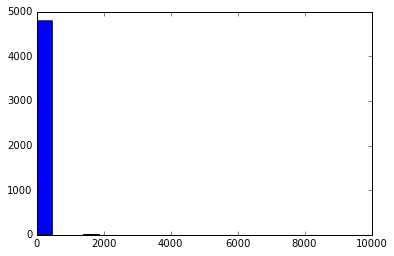

In [45]:
plt.hist(nes_df['EndingPriceAUD'], bins=20)

- Ideas for features:
    - Time of day
    - Need to refactor condition and rarity to have suitable comparison group (least rare/worst condition if sufficiently big)
    - Postage - worldwide vs other